# Gridded NetCDF modelresults

2D modelresults stored in NetCDF or Grib can be loaded to ModelSkill using xarray. In this way, MIKE 21 modelresults in dfsu format can easily be compared to model results from third party providers often stored in NetCDF. 

In [1]:
import xarray as xr
import modelskill as ms

## Observations

In [2]:
o1 = ms.PointObservation('examples/metocean/HKNA_Hm0.dfs0', item=0, x=4.2420, y=52.6887, name="HKNA")
o2 = ms.PointObservation("examples/metocean/eur_Hm0.dfs0", item=0, x=3.2760, y=51.9990, name="EPL")
o3 = ms.TrackObservation("examples/metocean/Alti_c2_Dutch.dfs0", item=3, name="c2")

## MIKE ModelResult

In [30]:
mrMIKE = ms.model_result('examples/metocean/HKZN_local_2017_DutchCoast.dfsu', name='MIKE21SW', item=0)
mrMIKE2 = ms.model_result('examples/metocean/DutchCoast_2017_subset_v2.dfsu', name='MIKE21SW_v2', item=0)

## NetCDF ModelResult

In [4]:
fn = "examples/metocean/ERA5_DutchCoast.nc"
xr.open_dataset(fn)

<xarray.Dataset>
Dimensions:    (longitude: 20, latitude: 11, time: 67)
Coordinates:
  * longitude  (longitude) float32 -1.0 -0.5 0.0 0.5 1.0 ... 6.5 7.0 7.5 8.0 8.5
  * latitude   (latitude) float32 55.0 54.5 54.0 53.5 ... 51.5 51.0 50.5 50.0
  * time       (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    mwd        (time, latitude, longitude) float32 ...
    mwp        (time, latitude, longitude) float32 ...
    mp2        (time, latitude, longitude) float32 ...
    pp1d       (time, latitude, longitude) float32 ...
    swh        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

In [5]:
mrERA5 = ms.model_result(fn, item="swh", name='ERA5')

In [6]:
mrERA5

<GridModelResult> 'ERA5'

In [7]:
mrERA5.data  # mr contains the xr.Dataset

<xarray.Dataset>
Dimensions:  (time: 67, y: 11, x: 20)
Coordinates:
  * x        (x) float32 -1.0 -0.5 0.0 0.5 1.0 1.5 ... 6.0 6.5 7.0 7.5 8.0 8.5
  * y        (y) float32 55.0 54.5 54.0 53.5 53.0 52.5 52.0 51.5 51.0 50.5 50.0
  * time     (time) datetime64[ns] 2017-10-27 ... 2017-10-29T18:00:00
Data variables:
    swh      (time, y, x) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-07 12:25:02 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

## Test extract from XArray

1) Extract point 
2) Extract track

In [8]:
mrERA5.extract(o1).data.head()

<xarray.Dataset>
Dimensions:  (time: 5)
Coordinates:
  * time     (time) datetime64[ns] 2017-10-27 ... 2017-10-27T04:00:00
    x        float64 4.242
    y        float64 52.69
    z        object None
Data variables:
    ERA5     (time) float32 1.22 1.347 1.466 1.612 1.793
Attributes:
    gtype:               point
    modelskill_version:  1.0.b0

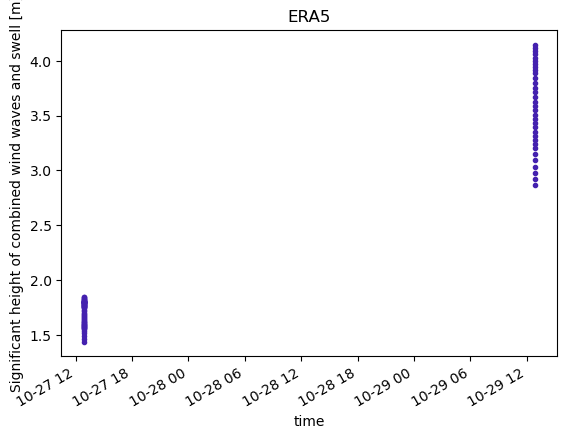

In [26]:
mrERA5.extract(o3).plot()

## Multi-file ModelResult

Use mfdataset to load multiple files as a single ModelResult.

In [10]:
fn = "examples/metocean/CMEMS_DutchCoast_*.nc"
mrCMEMS = ms.model_result(fn, item="VHM0", name='CMEMS')
mrCMEMS

<GridModelResult> 'CMEMS'

In [21]:
mrCMEMS.data

<xarray.Dataset>
Dimensions:  (time: 15, y: 27, x: 51)
Coordinates:
  * time     (time) datetime64[ns] 2017-10-28 ... 2017-10-29T18:00:00
  * x        (x) float32 -1.4 -1.2 -1.0 -0.8 -0.6 -0.4 ... 7.8 8.0 8.2 8.4 8.6
  * y        (y) float32 50.0 50.2 50.4 50.6 50.8 ... 54.4 54.6 54.8 55.0 55.2
Data variables:
    VHM0     (time, y, x) float32 dask.array<chunksize=(8, 27, 51), meta=np.ndarray>
Attributes: (12/30)
    CDI:                           Climate Data Interface version 1.9.3 (http...
    Conventions:                   CF-1.6
    CDO:                           Climate Data Operators version 1.9.3 (http...
    time_coverage_start:           20171028-00:00:00
    time_coverage_end:             20171028-21:00:00
    date_created:                  20200406-10:30:00
    ...                            ...
    geospatial_lat_step:           0.2
    geospatial_lat_units:          degree
    version:                       1.1
    product_type:                  Multi Year Product
    institution:                   Meteo France and Mercator Ocean
    title:                         Mean fields from global wave model MFWAM o...

## Match multiple models and observations and extract

<Axes: >

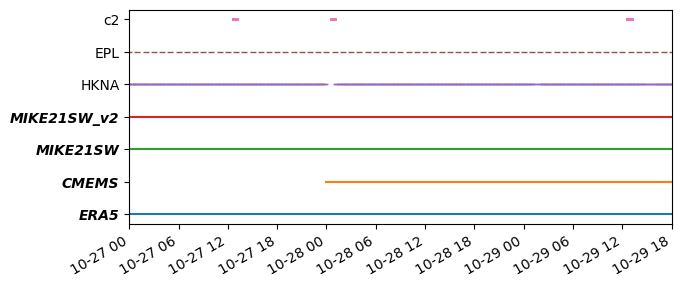

In [34]:
ms.plotting.temporal_coverage(obs=[o1,o2,o3], mod=[mrERA5, mrCMEMS, mrMIKE, mrMIKE2]);

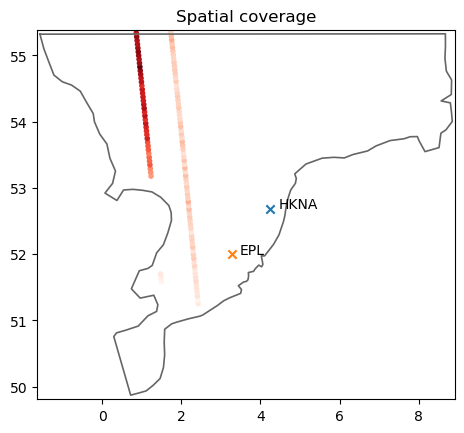

In [33]:
ms.plotting.spatial_overview(obs=[o1,o2,o3], mod=mrMIKE);

In [35]:
cc = ms.match(obs=[o1,o2,o3], mod=[mrERA5, mrCMEMS, mrMIKE, mrMIKE2])

## Analysis and plotting
Which model is better? 

In [36]:
sk = cc.skill()
sk.swaplevel().sort_index(level="observation").style()

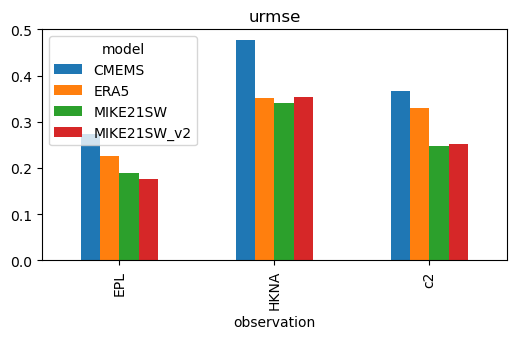

In [37]:
sk["urmse"].plot.bar(figsize=(6,3));

In [38]:
cc.mean_skill().style()

,n,bias,rmse,urmse,mae,cc,si,r2
model,,,,,,,,
CMEMS,301,-0.422,0.592,0.372,0.496,0.911,0.106,0.371
ERA5,301,-0.389,0.494,0.303,0.410,0.936,0.087,0.461
MIKE21SW,301,0.020,0.354,0.259,0.291,0.935,0.074,0.657
MIKE21SW_v2,301,-0.100,0.364,0.260,0.298,0.935,0.074,0.720


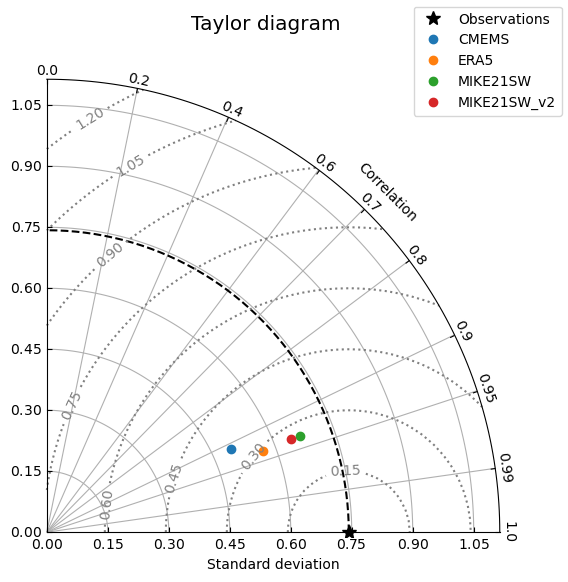

In [43]:
cc.plot.taylor(figsize=6);